In [7]:
import concurrent.futures
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def printing(time, statement1):

    
    print(statement1, time)
    return 1

# Fixed argument
fixed = ('fixed variable 1', 'fixed_variable2')

# Arguments for the function
times = [1,2,3,4,5]

# Using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Using submit with partial to fix one argument
    futures = [executor.submit(partial(printing, fixed), time) for time in times]
    
    # Retrieve results in the order of submission
    results = [future.result() for future in futures]

print(results)

TypeError: 'int' object is not callable

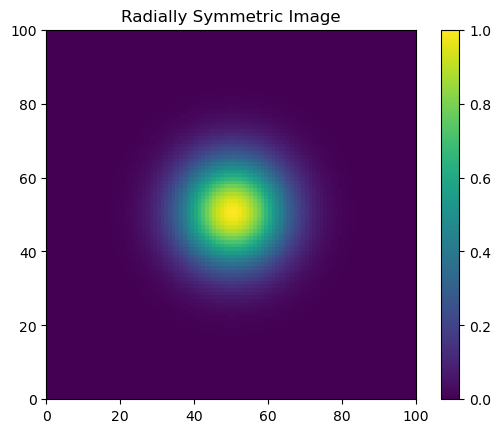

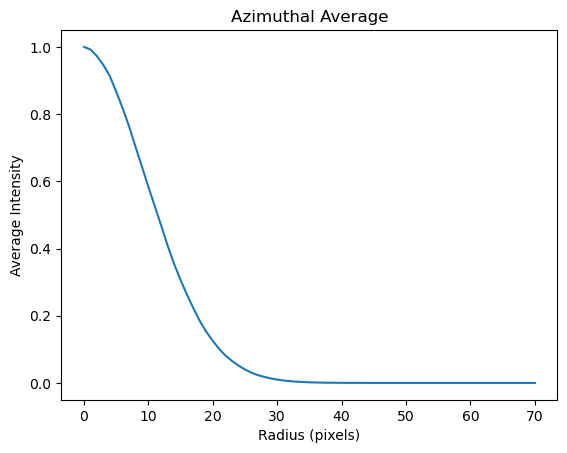

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def azimuthal_average(image, center=None, binsize=1.0):
    """
    Compute the azimuthal average of a 2D radially symmetric image.

    Parameters:
    - image: 2D numpy array, the input image.
    - center: tuple (x, y), the center around which to compute the average. If None, use the center of the image.
    - binsize: float, the size of the bins for averaging.

    Returns:
    - radial_prof: 1D numpy array, the azimuthally averaged radial profile.
    """
    # Ensure the input image is a 2D array
    assert image.ndim == 2, "Input image must be a 2D array"

    # Get the image dimensions
    y, x = np.indices(image.shape)

    if center is None:
        center = np.array([image.shape[1]//2, image.shape[0]//2])

    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)

    # Calculate the radial profile
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())

    radial_prof = tbin / nr

    return radial_prof


# Generate a synthetic radially symmetric image
size = 100
y, x = np.indices((size, size))
center = (50, 50)
radius = np.hypot(x - center[0], y - center[1])
image = np.exp(-(radius**2) / (2.0 * (10**2)))

# Compute the azimuthal average
radial_profile = azimuthal_average(image, center=center)

# Plot the results
plt.figure()
plt.imshow(image, origin='lower', extent=[0, size, 0, size])
plt.colorbar()
plt.title('Radially Symmetric Image')
plt.figure()
plt.plot(radial_profile)
plt.title('Azimuthal Average')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Intensity')
plt.show()


In [1]:
import h5py
import numpy as np

# Create a new HDF5 file
with h5py.File('example.h5', 'w') as f:
    # Create four groups
    group1 = f.create_group('group1')
    group2 = f.create_group('group2')
    group3 = f.create_group('group3')
    group4 = f.create_group('group4')
    
    # Optionally, add datasets to each group
    data1 = np.random.random(size=(100,))
    data2 = np.random.random(size=(200,))
    data3 = np.random.random(size=(300,))
    data4 = np.random.random(size=(400,))
    
    group1.create_dataset('dataset1', data=data1)
    group2.create_dataset('dataset2', data=data2)
    group3.create_dataset('dataset3', data=data3)
    group4.create_dataset('dataset4', data=data4)
    
    # Optionally, add attributes to each group
    group1.attrs['description'] = 'This is the first group'
    group2.attrs['description'] = 'This is the second group'
    group3.attrs['description'] = 'This is the third group'
    group4.attrs['description'] = 'This is the fourth group'

print("HDF5 file created successfully.")


HDF5 file created successfully.


In [2]:
# Open the HDF5 file in read mode
with h5py.File('example.h5', 'r') as f:
    # Access groups
    group1 = f['group1']
    group2 = f['group2']
    group3 = f['group3']
    group4 = f['group4']
    
    # Print group names
    print("Groups in the file:")
    for group in f.keys():
        print(group)
    
    # Access and print datasets within each group
    dataset1 = group1['dataset1'][:]
    dataset2 = group2['dataset2'][:]
    dataset3 = group3['dataset3'][:]
    dataset4 = group4['dataset4'][:]
    
    print("\nDatasets:")
    print("dataset1:", dataset1)
    print("dataset2:", dataset2)
    print("dataset3:", dataset3)
    print("dataset4:", dataset4)
    
    # Access and print attributes of each group
    attr1 = group1.attrs['description']
    attr2 = group2.attrs['description']
    attr3 = group3.attrs['description']
    attr4 = group4.attrs['description']
    
    print("\nAttributes:")
    print("group1 description:", attr1)
    print("group2 description:", attr2)
    print("group3 description:", attr3)
    print("group4 description:", attr4)

print("HDF5 file read successfully.")


Groups in the file:
group1
group2
group3
group4

Datasets:
dataset1: [0.11266975 0.06862246 0.20963446 0.89886855 0.38386078 0.85966953
 0.37188398 0.93963536 0.07863551 0.05392171 0.54644851 0.90994579
 0.46568627 0.98375156 0.21283634 0.60269527 0.38854138 0.12492964
 0.75284548 0.6489009  0.48156988 0.73892142 0.58789893 0.65802714
 0.62963282 0.48411763 0.05317347 0.62626405 0.59689788 0.68023699
 0.29697097 0.75443258 0.22153518 0.51671899 0.82700716 0.6394304
 0.33159141 0.36728134 0.80114263 0.83427973 0.69743751 0.26964717
 0.66069736 0.37339278 0.26606836 0.66216922 0.63844492 0.10670163
 0.4249906  0.55296278 0.85826517 0.2858259  0.72463315 0.1214654
 0.25752532 0.48654309 0.91520627 0.17733439 0.89400998 0.61603991
 0.74899131 0.82896854 0.20137561 0.8602125  0.61349282 0.73241841
 0.82058951 0.10092524 0.06096694 0.60753663 0.52403206 0.78355874
 0.51218077 0.89945228 0.19846509 0.10648384 0.53253286 0.68633746
 0.75243791 0.82231267 0.1637345  0.3883189  0.51235725 0.1259

In [3]:
import h5py

# Open the HDF5 file in read mode
with h5py.File('example.h5', 'r') as f:
    # Access groups
    group1 = f['group1']
    group2 = f['group2']
    group3 = f['group3']
    group4 = f['group4']
    
    # Access and print datasets within each group
    dataset1 = group1['dataset1'][:]
    dataset2 = group2['dataset2'][:]
    dataset3 = group3['dataset3'][:]
    dataset4 = group4['dataset4'][:]
    
    print("Datasets:")
    print("dataset1:", dataset1)
    print("dataset2:", dataset2)
    print("dataset3:", dataset3)
    print("dataset4:", dataset4)
    
    # Access and print attributes of each group
    attr1 = group1.attrs['description']
    attr2 = group2.attrs['description']
    attr3 = group3.attrs['description']
    attr4 = group4.attrs['description']
    
    print("Attributes:")
    print("group1 description:", attr1)
    print("group2 description:", attr2)
    print("group3 description:", attr3)
    print("group4 description:", attr4)

print("HDF5 file read successfully.")


Datasets:
dataset1: [0.11266975 0.06862246 0.20963446 0.89886855 0.38386078 0.85966953
 0.37188398 0.93963536 0.07863551 0.05392171 0.54644851 0.90994579
 0.46568627 0.98375156 0.21283634 0.60269527 0.38854138 0.12492964
 0.75284548 0.6489009  0.48156988 0.73892142 0.58789893 0.65802714
 0.62963282 0.48411763 0.05317347 0.62626405 0.59689788 0.68023699
 0.29697097 0.75443258 0.22153518 0.51671899 0.82700716 0.6394304
 0.33159141 0.36728134 0.80114263 0.83427973 0.69743751 0.26964717
 0.66069736 0.37339278 0.26606836 0.66216922 0.63844492 0.10670163
 0.4249906  0.55296278 0.85826517 0.2858259  0.72463315 0.1214654
 0.25752532 0.48654309 0.91520627 0.17733439 0.89400998 0.61603991
 0.74899131 0.82896854 0.20137561 0.8602125  0.61349282 0.73241841
 0.82058951 0.10092524 0.06096694 0.60753663 0.52403206 0.78355874
 0.51218077 0.89945228 0.19846509 0.10648384 0.53253286 0.68633746
 0.75243791 0.82231267 0.1637345  0.3883189  0.51235725 0.12596585
 0.97145365 0.93574637 0.66339821 0.64947669